# This notebook test the difference between the triaging time of the current and next release when approaching the next release.

In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import unittest
from global_functions import *
from rq3_functions import *

In [2]:
FIGS_PATH = 'figs'+os.sep+'RQ3'
if not os.path.exists(FIGS_PATH):
    os.makedirs(FIGS_PATH)

In [3]:
release_creation_ts_all = get_release_dates()

In [4]:
yearly_file = 'data'+os.sep+'bugs_info.zip'
df_monthly = pd.read_csv(yearly_file,index_col=False,compression='zip',
                                        dtype={'release': str})
df_monthly['release'] = df_monthly.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df_monthly.head()

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaN,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,NaN,0.0,0.0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaN,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,NaN,0.0,0.0,4.6,4.6,False,False
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
3,475379,4.5,Platform,2015-08-19 13:39:12,4.5,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaN,...,2015-08-19 17:15:25,2015-08-19 17:15:25,2015-08-19 17:15:25,NaN,0.0,0.0,4.5,4.5,False,False


# TRIAGING PRE-ANALYSIS

In [5]:
e_target_file_next_release = 'data'+os.sep+'RQ3'+os.sep+'releases_monthly_stats_first_assign_E_2.zip'
if not os.path.exists(e_target_file_next_release):
    df_monthly_stats_first_next_release_triaging = get_monthly_triaging_stats_next(df_monthly,release_creation_ts_all,assignedFirst=True,resolvedFirst=False)
    df_monthly_stats_first_next_release_triaging.to_csv(e_target_file_next_release,index=False,compression='zip')
else:
    df_monthly_stats_first_next_release_triaging = pd.read_csv(e_target_file_next_release,index_col=False,compression='zip',
                                          dtype={'release': str,'predecessor': str})
df_monthly_stats_first_next_release_triaging.head()

,id,release,Product,creation_time,first_assignment_date,type,start_period,end_period,month,period
0,64617,3.0,Platform,2004-05-28 19:41:39,2004-06-09 10:40:07,assigned,2004-05-26,2004-06-25,1,before
1,64621,3.0,Platform,2004-05-28 19:43:31,2004-05-28 20:08:49,assigned,2004-05-26,2004-06-25,1,before
2,64626,3.0,Platform,2004-05-28 19:57:21,2004-05-28 19:57:31,assigned,2004-05-26,2004-06-25,1,before
3,64627,3.0,Platform,2004-05-28 20:09:59,2004-05-28 20:22:12,assigned,2004-05-26,2004-06-25,1,before
4,64628,3.0,Platform,2004-05-28 20:18:48,2004-05-28 20:20:15,assigned,2004-05-26,2004-06-25,1,before


In [6]:
#We reverse the months because our target becomes the next release date; so the 1st month before the next release becomes the 12th month as it is the month just before the next release
df_monthly_stats_first_next_release_triaging['month'] = df_monthly_stats_first_next_release_triaging.apply(lambda x : reverse_month(x['month']), axis=1)

In [7]:
#the traiging time of the NEXT release bugs when approching the next release
file_target_e = 'data'+os.sep+'RQ3'+os.sep+'time_assign_E_2.csv.gz'
if not os.path.exists(file_target_e):
    df_total_next_triaging = df_monthly_stats_first_next_release_triaging.copy()
    df_total_next_triaging = trans_to_datetime(df_total_next_triaging,['first_assignment_date','creation_time'])
    df_total_next_triaging['triaging_time'] =df_total_next_triaging.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
    df_total_next_triaging = df_total_next_triaging[['id','month','triaging_time' ,'release' ]]
    
    df_total_next_triaging.to_csv(file_target_e,index=False,compression='gzip')
else:
    df_total_next_triaging = pd.read_csv(file_target_e,index_col=False,compression='gzip',dtype={'release':str})
df_total_next_triaging['type']='next'
df_total_next_triaging.head()

,id,month,triaging_time,release,type
0,64617,12,11,3.0,next
1,64621,12,0,3.0,next
2,64626,12,0,3.0,next
3,64627,12,0,3.0,next
4,64628,12,0,3.0,next


In [8]:
e_target_file = 'data'+os.sep+'RQ3'+os.sep+'releases_monthly_stats_first_assign_E.zip'
if not os.path.exists(e_target_file):
    df_monthly_stats_first_current_triaging = get_monthly_triaging_stats_current(df_monthly,release_creation_ts_all,assignedFirst=True,resolvedFirst=False)
    df_monthly_stats_first_current_triaging.to_csv(e_target_file,index=False,compression='zip')
else:
    df_monthly_stats_first_current_triaging = pd.read_csv(e_target_file,index_col=False,compression='zip',
                                          dtype={'release': str,'predecessor': str})
    
df_monthly_stats_first_current_triaging['release'] = df_monthly_stats_first_current_triaging['release'].astype(str)
df_monthly_stats_first_current_triaging.head()

,id,release,Product,creation_time,first_assignment_date,type,start_period,end_period,month,period,predecessor
0,101046,3.1,Platform,2005-06-21 13:53:26,2005-06-21 13:56:07,assigned,2005-05-29,2005-06-28,1,before,3.0
1,101423,3.1,Platform,2005-06-23 10:44:50,2005-06-23 16:32:38,assigned,2005-05-29,2005-06-28,1,before,3.0
2,101428,3.1,Platform,2005-06-23 12:03:08,2005-06-23 13:16:25,assigned,2005-05-29,2005-06-28,1,before,3.0
3,101447,3.1,Platform,2005-06-23 14:08:29,2005-06-23 15:32:30,assigned,2005-05-29,2005-06-28,1,before,3.0
4,101634,3.1,Platform,2005-06-24 14:05:51,2005-06-24 14:40:07,assigned,2005-05-29,2005-06-28,1,before,3.0


In [9]:
#We reverse the months because our target becomes the next release date; so the 1st month before the next release becomes the 12th month as it is the month just before the next release
df_monthly_stats_first_current_triaging['month'] = df_monthly_stats_first_current_triaging.apply(lambda x : reverse_month(x['month']), axis=1)

In [10]:
file_target_e = 'data'+os.sep+'RQ3'+os.sep+'time_assign_E.csv.gz'
if not os.path.exists(file_target_e):
    df_total_current_triaging = df_monthly_stats_first_current_triaging.copy()
    df_total_current_triaging = trans_to_datetime(df_total_current_triaging,['first_assignment_date','creation_time'])
    df_total_current_triaging['triaging_time'] =df_total_current_triaging.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
    df_total_current_triaging = df_total_current_triaging[['id','month','triaging_time' ,'release' ]]
    
    df_total_current_triaging.to_csv(file_target_e,index=False,compression='gzip')
else:
    df_total_current_triaging = pd.read_csv(file_target_e,index_col=False,compression='gzip',dtype={'release':str})

df_total_current_triaging['type']='current'
df_total_current_triaging.head()

,id,month,triaging_time,release,type
0,101046,12,0,3.1,current
1,101423,12,0,3.1,current
2,101428,12,0,3.1,current
3,101447,12,0,3.1,current
4,101634,12,0,3.1,current


# FIXING PRE-ANALYSIS

In [11]:
e_target_file = 'data'+os.sep+'RQ3'+os.sep+'releases_monthly_stats_last_fix_E_2.zip'
if not os.path.exists(e_target_file):
    df_monthly_stats_first_next_release_fixing = get_monthly_fixing_stats_next(df_monthly,release_creation_ts_all,assignedFirst=True,fixedFirst=False)
    df_monthly_stats_first_next_release_fixing.to_csv(e_target_file,index=False,compression='zip')
else:
    df_monthly_stats_first_next_release_fixing = pd.read_csv(e_target_file,index_col=False,compression='zip',
                                          dtype={'release': str,'predecessor': str})

df_monthly_stats_first_next_release_fixing.head()

,id,release,Product,creation_time,last_fixed_date,type,start_period,end_period,month,period
0,64614,3.0,Platform,2004-05-28 19:29:59,2004-06-03 19:24:42,fixed,2004-05-26,2004-06-25,1,before
1,64617,3.0,Platform,2004-05-28 19:41:39,2004-06-09 10:40:47,fixed,2004-05-26,2004-06-25,1,before
2,64626,3.0,Platform,2004-05-28 19:57:21,2004-06-07 16:10:42,fixed,2004-05-26,2004-06-25,1,before
3,64627,3.0,Platform,2004-05-28 20:09:59,2004-06-08 02:17:03,fixed,2004-05-26,2004-06-25,1,before
4,64629,3.0,Platform,2004-05-28 20:19:41,2004-05-28 21:24:51,fixed,2004-05-26,2004-06-25,1,before


In [12]:
#We reverse the month the same way
df_monthly_stats_first_next_release_fixing['month'] = df_monthly_stats_first_next_release_fixing.apply(lambda x : reverse_month(x['month']), axis=1)

In [13]:
file_target_e = 'data'+os.sep+'RQ3'+os.sep+'time_fix_E_2.csv.gz'
if not os.path.exists(file_target_e):
    df_total_next_fixing=df_monthly_stats_first_next_release_fixing.copy()
    df_total_next_fixing = trans_to_datetime(df_total_next_fixing,['last_fixed_date','creation_time'])
    df_total_next_fixing['fixing_time'] =df_total_next_fixing.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
    df_total_next_fixing= df_total_next_fixing[['id','month','fixing_time' ,'release' ]]
    
    df_total_next_fixing.to_csv(file_target_e,index=False,compression='gzip')
else:
    df_total_next_fixing = pd.read_csv(file_target_e,index_col=False,compression='gzip',dtype={'release':str})

df_total_next_fixing['type']='next'
df_total_next_fixing.head()

,id,month,fixing_time,release,type
0,64614,12,5,3.0,next
1,64617,12,11,3.0,next
2,64626,12,9,3.0,next
3,64627,12,10,3.0,next
4,64629,12,0,3.0,next


In [14]:
e_t_file = 'data'+os.sep+'RQ3'+os.sep+'releases_monthly_stats_last_fix_E.csv'
if not os.path.exists(e_t_file):
    df_monthly_stats_first_current_release_fixing = get_monthly_fixing_stats_current(df_monthly,release_creation_ts_all,list(release_creation_ts_all.keys()),fixedFirst=False,resolvedFirst=False)
    df_monthly_stats_first_current_release_fixing.to_csv(e_t_file,index=False)
else:
    df_monthly_stats_first_current_release_fixing = pd.read_csv(e_t_file,index_col=False,
                                          dtype={'release': str})
    
df_monthly_stats_first_current_release_fixing['release'] = df_monthly_stats_first_current_release_fixing['release'].astype(str)
df_monthly_stats_first_current_release_fixing.head()

,id,release,Product,creation_time,last_fixed_date,type,start_period,end_period,month,period,predecessor
0,100923,3.1,Platform,2005-06-20 18:16:37,2005-06-22 12:54:30,fixed,2005-05-29,2005-06-28,1,before,3.0
1,101160,3.1,Platform,2005-06-21 22:03:45,2005-06-22 19:59:40,fixed,2005-05-29,2005-06-28,1,before,3.0
2,65216,3.1,Platform,2004-06-02 02:58:22,2005-06-09 18:21:31,fixed,2005-05-29,2005-06-28,1,before,3.0
3,65775,3.1,Platform,2004-06-04 18:22:30,2005-06-16 18:09:38,fixed,2005-05-29,2005-06-28,1,before,3.0
4,65786,3.1,Platform,2004-06-04 19:11:53,2005-06-02 16:29:39,fixed,2005-05-29,2005-06-28,1,before,3.0


In [15]:
#We reverse the month the same way
df_monthly_stats_first_current_release_fixing['month'] = df_monthly_stats_first_current_release_fixing.apply(lambda x : reverse_month(x['month']), axis=1)

In [16]:
e_target_file = 'data'+os.sep+'RQ3'+os.sep+'time_fix_E.csv.gz'
if not os.path.exists(e_target_file):
    df_total_current_fixing=df_monthly_stats_first_current_release_fixing.copy()
    df_total_current_fixing = trans_to_datetime(df_total_current_fixing,['last_fixed_date','creation_time'])
    df_total_current_fixing['fixing_time'] =df_total_current_fixing.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
    df_total_current_fixing= df_total_current_fixing[['id','month','fixing_time' ,'release' ]]        
        
    df_total_current_fixing.to_csv(e_target_file,index=False,compression='gzip')
else:
    df_total_current_fixing=pd.read_csv(e_target_file,index_col=False,compression='gzip',
                                          dtype={'release': str})
df_total_current_fixing['type']='current'
df_total_current_fixing.head()    

,id,month,fixing_time,release,type
0,100923,12,1,3.1,current
1,101160,12,0,3.1,current
2,65216,12,372,3.1,current
3,65775,12,376,3.1,current
4,65786,12,362,3.1,current


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


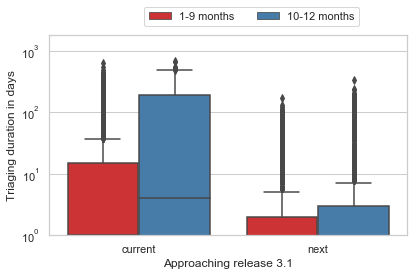

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


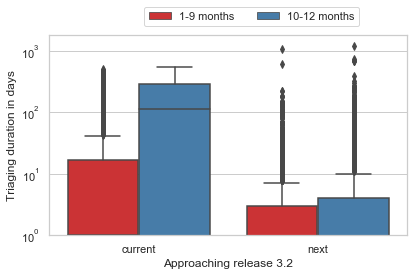

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


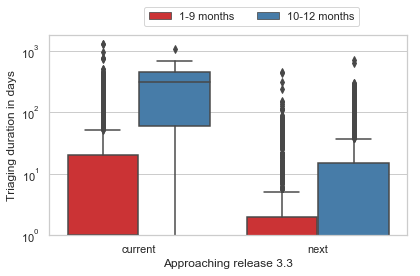

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


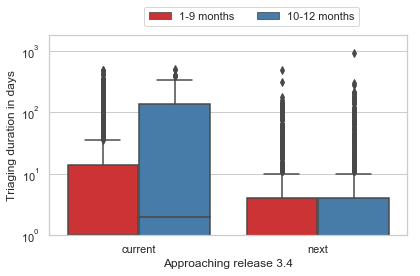

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


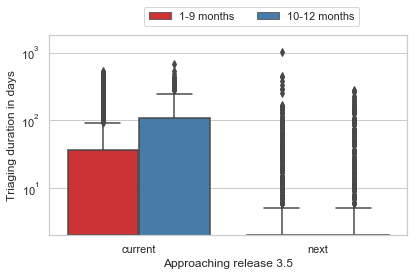

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


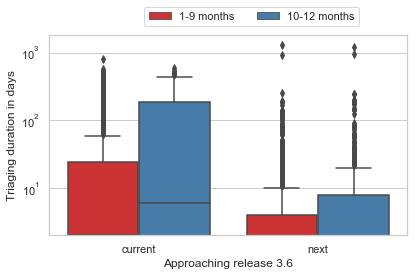

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


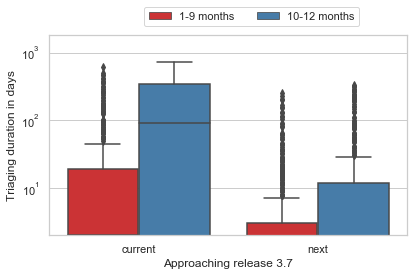

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


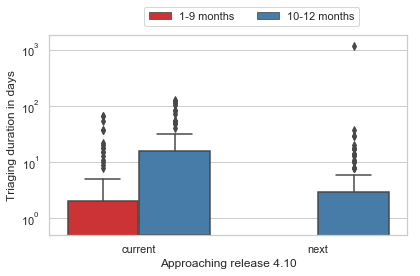

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


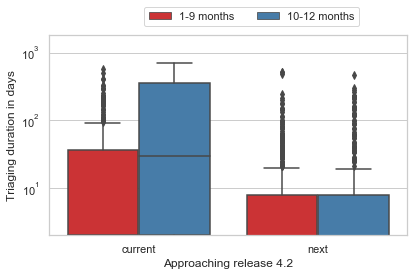

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


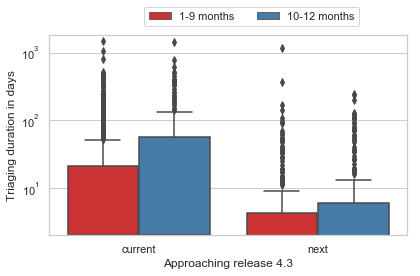

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


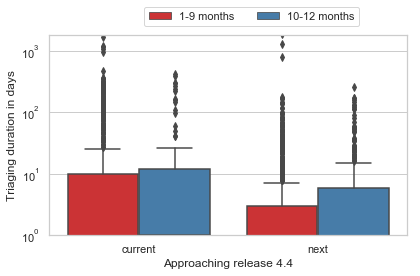

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


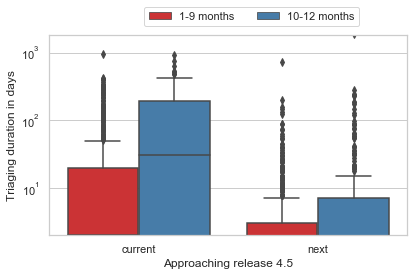

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


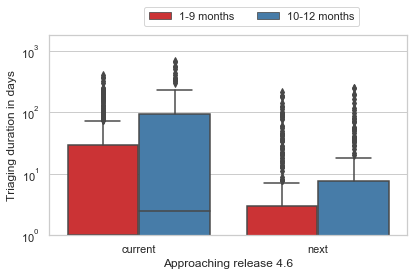

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


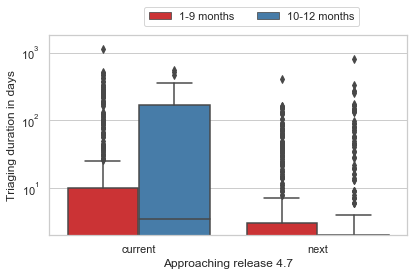

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


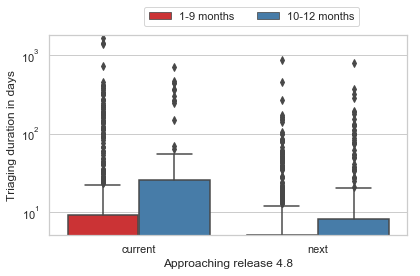

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


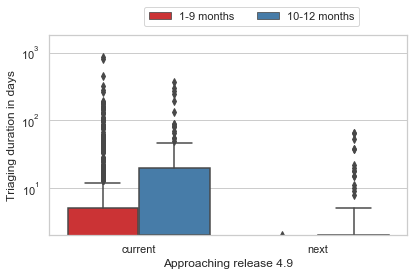

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


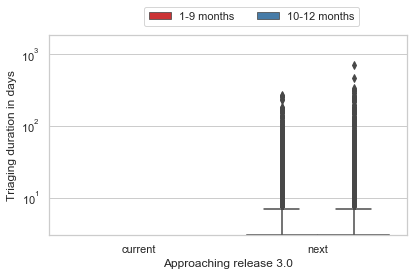

,id,month,triaging_time,release,type
0,101046,12,0,3.1,current
1,101423,12,0,3.1,current
2,101428,12,0,3.1,current
3,101447,12,0,3.1,current
4,101634,12,0,3.1,current


In [17]:
#Triaging figures
df_triaging = pd.DataFrame()
df_triaging = df_triaging.append(df_total_current_triaging,ignore_index=True)
df_triaging = df_triaging.append(df_total_next_triaging,ignore_index=True)

for release in df_triaging.release.unique():
    release_numbers = df_triaging[df_triaging['release']==release]
    
    release_numbers['period'] = release_numbers.apply(lambda x: '1-9 months' if x['month']<=9 else '10-12 months', axis=1)
    

    sns.set(style="whitegrid")
    ax = plt.subplot(1, 1,1)

    g=sns.boxplot(x="type", y="triaging_time", hue="period",
          data=release_numbers, palette="Set1",hue_order=['1-9 months','10-12 months'], order=["current", "next"])
    ax.set_xlabel("Approaching release "+release)
    ax.set_ylabel("Triaging duration in days")
    ax.set_yscale('log')
    ax.set_ylim(0, 1800)
    plt.legend(bbox_to_anchor=(0.25, 1.02, 1., .102), loc='lower left',ncol=2)
    
    plt.tight_layout( )
    plt.show()
    ax.get_figure().savefig(FIGS_PATH+os.sep+'triaging_final'+release.replace('.', '-')+'.pdf', bbox_inches="tight")

df_triaging.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


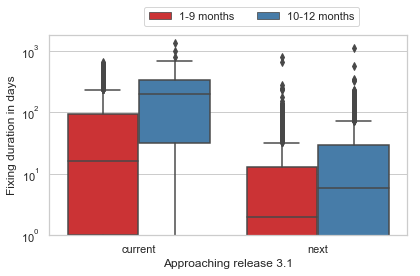

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


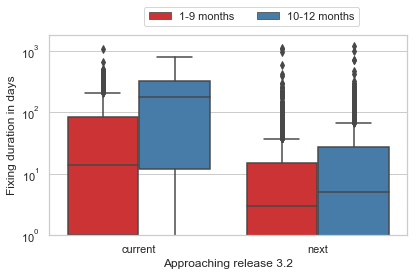

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


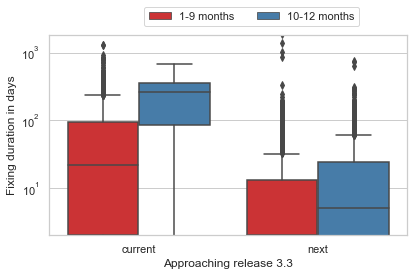

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


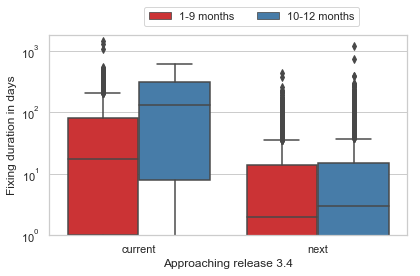

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


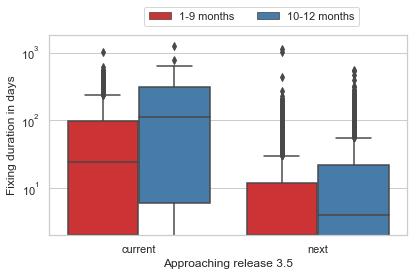

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


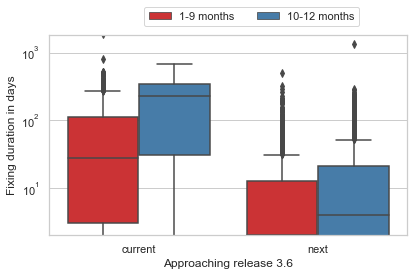

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


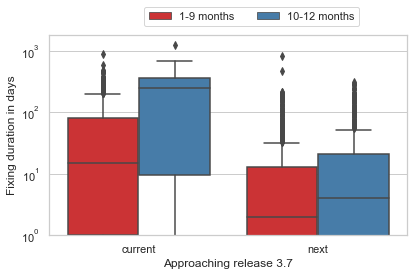

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


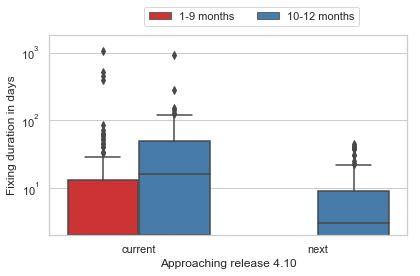

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


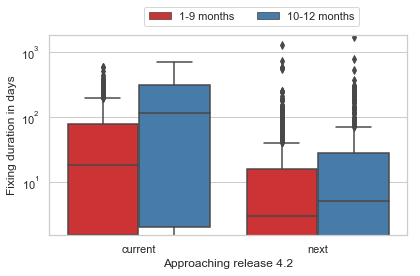

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


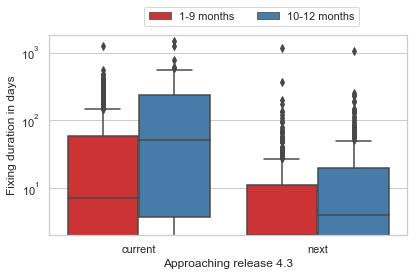

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


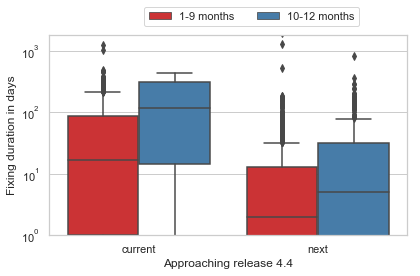

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


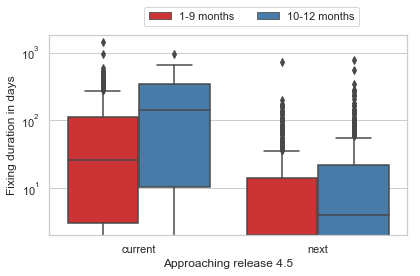

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


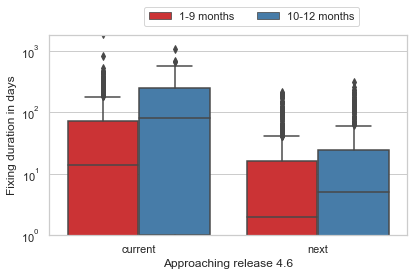

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


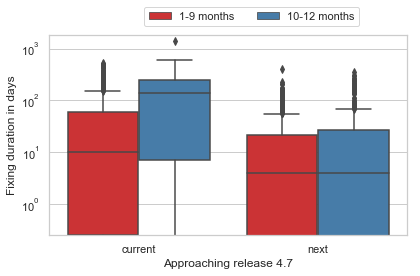

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


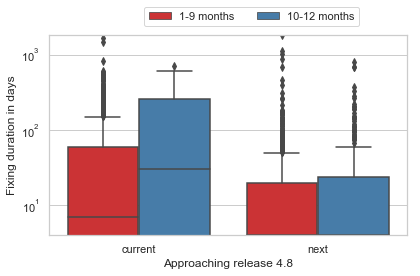

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


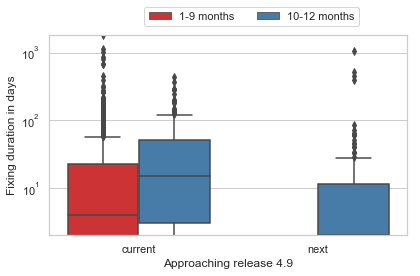

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


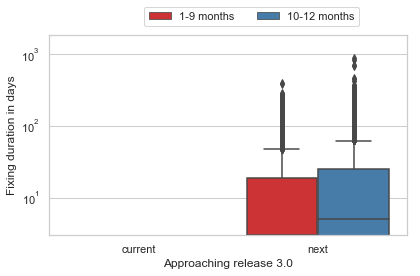

,id,month,triaging_time,release,type
0,101046,12,0,3.1,current
1,101423,12,0,3.1,current
2,101428,12,0,3.1,current
3,101447,12,0,3.1,current
4,101634,12,0,3.1,current


In [18]:
#Fixing figures
df_fixing = pd.DataFrame()
df_fixing = df_fixing.append(df_total_current_fixing,ignore_index=True)
df_fixing = df_fixing.append(df_total_next_fixing,ignore_index=True)

for release in df_fixing.release.unique():
    release_numbers = df_fixing[df_fixing['release']==release]
    
    release_numbers['period'] = release_numbers.apply(lambda x: '1-9 months' if x['month']<=9 else '10-12 months', axis=1)
    

    sns.set(style="whitegrid")
    ax = plt.subplot(1, 1,1)

    g=sns.boxplot(x="type", y="fixing_time", hue="period",
          data=release_numbers, palette="Set1",hue_order=['1-9 months','10-12 months'], order=["current", "next"])
    ax.set_xlabel("Approaching release "+release)
    ax.set_ylabel("Fixing duration in days")
    ax.set_yscale('log')
    ax.set_ylim(0, 1800)
    plt.legend(bbox_to_anchor=(0.25, 1.02, 1., .102), loc='lower left',ncol=2)
    
    plt.tight_layout( )
    plt.show()
    ax.get_figure().savefig(FIGS_PATH+os.sep+'fixing_final'+release.replace('.', '-')+'.pdf', bbox_inches="tight")

df_triaging.head()

# First analysis:
## investigate the bug activity of the current and next release for the pressure period

In [19]:
#Test if there is a statistically significant difference between 
#TRIAGING time for the current and next release in the last 3 months

print('triaging time for the current and next release in the last 3 months')


last_3months_triaging = pd.DataFrame()
last_3months_triaging = last_3months_triaging.append(df_total_next_triaging[df_total_next_triaging['month'].isin([10,11,12])])
last_3months_triaging = last_3months_triaging.append(df_total_current_triaging[df_total_current_triaging['month'].isin([10,11,12])])

for release in last_3months_triaging.release.unique():
    if release=='4.10':
        continue
    print(release)
    
    
    last_3months_release = last_3months_triaging[last_3months_triaging['release']==release]
    
    current_sample = last_3months_release[last_3months_release['type']=='current'].triaging_time.values.tolist()
    next_sample = last_3months_release[last_3months_release['type']=='next'].triaging_time.values.tolist()

    if len(current_sample)==0 or len(next_sample)==0:
        print('At least one sample is empty - Aborting')
        print('=========')
        continue
        
    compare_distributions_uneven_samples(current_sample,next_sample,True)
    print('=========')

triaging time for the current and next release in the last 3 months
3.0
At least one sample is empty - Aborting
3.1
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=139186.0, pvalue=6.36486737629999e-19)
0.3236568962836262
small
3.2
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=84069.0, pvalue=1.6082615103975498e-46)
0.5263424775619897
large
3.3
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=87336.0, pvalue=1.16487464897112e-136)
0.7327727852690906
large
3.4
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=59057.5, pvalue=1.7213497625461956e-10)
0.28857099834362293
small
3.5
At least one sample not normally distributed
MANN WHITNEY U
Statistically signifi

In [20]:
#Test if there is a statistically significant difference between 
#FIXING time for the current and next release in the last 3 months

print('fixing time for the current and next release in the last 3 months')

last_3months_fixing = pd.DataFrame()
last_3months_fixing = last_3months_fixing.append(df_total_next_fixing[df_total_next_fixing['month'].isin([10,11,12])])
last_3months_fixing = last_3months_fixing.append(df_total_current_fixing[df_total_current_fixing['month'].isin([10,11,12])])

for release in last_3months_fixing.release.unique():
    if release=='4.10':
        continue
    print(release)
    
    last_3months_release = last_3months_fixing[last_3months_fixing['release']==release]
    
    current_sample = last_3months_release[last_3months_release['type']=='current'].fixing_time.values.tolist()
    next_sample = last_3months_release[last_3months_release['type']=='next'].fixing_time.values.tolist()

    if len(current_sample)==0 or len(next_sample)==0:
        print('At least one sample is empty - Aborting')
        print('=========')
        continue
        
    compare_distributions_uneven_samples(current_sample,next_sample,True)
    print('=========')

fixing time for the current and next release in the last 3 months
3.0
At least one sample is empty - Aborting
3.1
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=262207.5, pvalue=9.301040358395827e-134)
0.6461895624858318
large
3.2
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=145648.5, pvalue=2.641694302050045e-70)
0.572225975093985
large
3.3
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=79249.5, pvalue=4.59708318112343e-135)
0.7766707528427104
large
3.4
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=109703.5, pvalue=1.8574752201094777e-57)
0.5737840898715759
large
3.5
At least one sample not normally distributed
MANN WHITNEY U
Statistically signific

# Second analysis:
## for the current release, we investigate the differences in triaging and fixing time between the early period and the pressure period

In [21]:
#CURRENT RELEASE
#triaging time difference between the 1-9 months and 10-12 months
last_3months_current = df_total_current_triaging[df_total_current_triaging['month'].isin([10,11,12])]
first_9months_current = df_total_current_triaging[~df_total_current_triaging['month'].isin([10,11,12])]

releases = first_9months_current[['release']]
releases.append(last_3months_current[['release']],ignore_index=True)
releases = releases.drop_duplicates()
releases = sort_df(releases,'release')

print('triaging time for the current release in the last 3 months and first 9 months')
for release in releases.release.values.tolist():
    if release=='4.10':
        continue
    print(release)
    
    first_sample = first_9months_current[first_9months_current['release']==release].triaging_time.values.tolist()
    last_sample = last_3months_current[last_3months_current['release']==release].triaging_time.values.tolist()

    if len(first_sample)==0 or len(last_sample)==0:
        print('At least one sample is empty - Aborting')
        print('=========')
        continue
        
    compare_distributions_uneven_samples(first_sample,last_sample,True)
    print('=========')

triaging time for the current release in the last 3 months and first 9 months
3.1
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=195277.5, pvalue=1.4389651999131557e-07)
-0.197699642970127
small
3.2
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=108872.0, pvalue=4.201787926209043e-28)
-0.41690499908951656
medium
3.3
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=98459.0, pvalue=3.3963176662437554e-112)
-0.6801856670012311
large
3.4
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=70538.5, pvalue=0.0011933020077838869)
-0.14728761824171174
small
3.5
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found


In [22]:
#CURRENT RELEASE
#fixing time difference between the 1-9 months and 10-12 months
last_3months_current = df_total_current_fixing[df_total_current_fixing['month'].isin([10,11,12])]
first_9months_current = df_total_current_fixing[~df_total_current_fixing['month'].isin([10,11,12])]

releases = first_9months_current[['release']]
releases.append(last_3months_current[['release']],ignore_index=True)
releases = releases.drop_duplicates()
releases = sort_df(releases,'release')

print('fixing time for the current release in the last 3 months and first 9 months')
for release in releases.release.values.tolist():
    if release=='4.10':
        continue
    print(release)
    
    first_sample = first_9months_current[first_9months_current['release']==release].fixing_time.values.tolist()
    last_sample = last_3months_current[last_3months_current['release']==release].fixing_time.values.tolist()

    if len(first_sample)==0 or len(last_sample)==0:
        print('At least one sample is empty - Aborting')
        print('=========')
        continue
        
    compare_distributions_uneven_samples(first_sample,last_sample,True)
    print('=========')

fixing time for the current release in the last 3 months and first 9 months
3.1
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=388131.5, pvalue=1.4653794820901872e-76)
-0.4869866978952433
large
3.2
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=180839.0, pvalue=1.943966978279282e-38)
-0.4228112731799177
medium
3.3
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=137347.5, pvalue=4.559582700938334e-79)
-0.5973630980300187
large
3.4
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=159000.0, pvalue=1.4643630564853803e-22)
-0.35414686456581607
medium
3.5
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
Mann

# Third analysis:
## for the next release, we investigate the differences in triaging and fixing time between the early period and the pressure period

In [23]:
#CURRENT RELEASE
#triaging time difference between the 1-9 months and 10-12 months
last_3months_next = df_total_next_triaging[df_total_next_triaging['month'].isin([10,11,12])]
first_9months_next = df_total_next_triaging[~df_total_next_triaging['month'].isin([10,11,12])]

releases = first_9months_next[['release']]
releases.append(last_3months_next[['release']],ignore_index=True)
releases = releases.drop_duplicates()
releases = sort_df(releases,'release')

print('triaging time for the next release in the last 3 months and first 9 months')
for release in releases.release.values.tolist():
    if release=='4.10':
        continue
    print(release)
    
    first_sample = first_9months_next[first_9months_next['release']==release].triaging_time.values.tolist()
    last_sample = last_3months_next[last_3months_next['release']==release].triaging_time.values.tolist()

    if len(first_sample)==0 or len(last_sample)==0:
        print('At least one sample is empty - Aborting')
        print('=========')
        continue
        
    compare_distributions_uneven_samples(first_sample,last_sample,True)
    print('=========')

triaging time for the next release in the last 3 months and first 9 months
3.0
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuResult(statistic=4947775.0, pvalue=0.42083904517192083)
3.1
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=2060445.5, pvalue=0.0004418300518715487)
-0.05142315610751405
negligible
3.2
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=1627826.5, pvalue=0.0042604201139483655)
-0.0452095703894265
negligible
3.3
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=809150.5, pvalue=2.4936107576607946e-19)
-0.17240319480910002
small
3.4
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference NOT found
MannwhitneyuRe

In [24]:
#CURRENT RELEASE
#triaging time difference between the 1-9 months and 10-12 months
last_3months_next = df_total_next_fixing[df_total_next_fixing['month'].isin([10,11,12])]
first_9months_next = df_total_next_fixing[~df_total_next_fixing['month'].isin([10,11,12])]

releases = first_9months_next[['release']]
releases.append(last_3months_next[['release']],ignore_index=True)
releases = releases.drop_duplicates()
releases = sort_df(releases,'release')

print('fixing time for the next release in the last 3 months and first 9 months')
for release in releases.release.values.tolist():
    if release=='4.10':
        continue
    print(release)
    
    first_sample = first_9months_next[first_9months_next['release']==release].fixing_time.values.tolist()
    last_sample = last_3months_next[last_3months_next['release']==release].fixing_time.values.tolist()

    if len(first_sample)==0 or len(last_sample)==0:
        print('At least one sample is empty - Aborting')
        print('=========')
        continue
        
    compare_distributions_uneven_samples(first_sample,last_sample,True)
    print('=========')

fixing time for the next release in the last 3 months and first 9 months
3.0
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=6995152.0, pvalue=5.908618469103405e-12)
-0.08726151392297177
negligible
3.1
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=2387399.0, pvalue=1.8777932125054383e-31)
-0.18873519230422886
small
3.2
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=2124464.0, pvalue=1.237343427344436e-14)
-0.13148220826792256
negligible
3.3
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant difference found
MannwhitneyuResult(statistic=1579906.5, pvalue=3.410733680902332e-14)
-0.13691425855591202
negligible
3.4
At least one sample not normally distributed
MANN WHITNEY U
Statistically significant diffe